In [1]:
import h5py
import numpy as np
import george
import corner
import matplotlib.pyplot as plt
import plotting

In [2]:
filename = "../data/hdf5_testing/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt.hdf5"

(100, 10000, 4)
true_period
walkers
iterations
data_pts
acceptance_faction
0.4349383162033085
10000


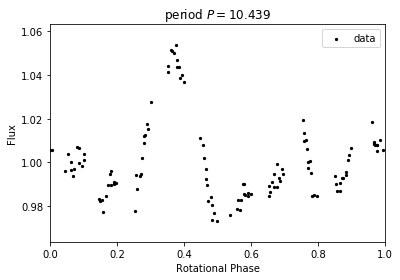

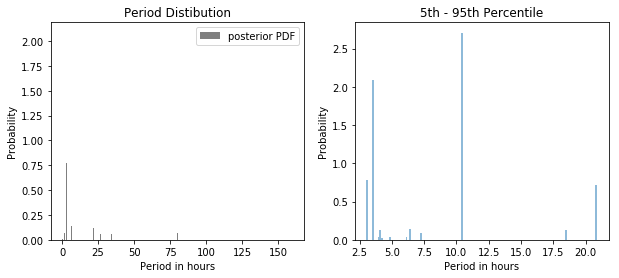

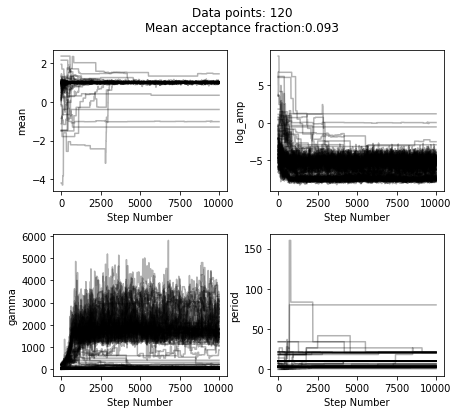

In [29]:
with h5py.File(filename, "r") as f:
    data = f['chain'][:]
    time = f['time'][:]
    flux = f["flux"][:]
    flux_err = f['flux_err'][:]
    true_period = f.attrs['true_period']
    print(data.shape)
    
    for key in f.attrs.keys():
        print(key)
    
    ###kernel###   
    # set up the gp kernel again
    #(because for some reason it can't be saved)
    mean_flux = np.mean(flux)
    log_amp = np.log(flux.max()-flux.min())
    gamma = 1
    log_period = 0

    params = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
    
    kernel = np.exp(params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = params["gamma"], log_period = params["log_period"])
    gp = george.GP(kernel, fit_mean=True, mean=params["mean"])
    gp.compute(time, flux_err)
   

    ##folded lightcurve###
    period = np.percentile(flat_data[:,3], 55)/24.
    print(period)
    plotting.plot_folded_lightcurve(time, flux, period=period)
    
    ###plot full corner plot###    
    data[:,:,3] = np.exp(data[:,:,3])*24.
    #print(f.attrs["iterations"])

    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'

    #corner.corner(data.reshape(f.attrs["walkers"]*f.attrs['iterations'],4), labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 10})
    #plt.savefig(namestr + "_corner.pdf", format="pdf")

        
        
    ###plot the 5-95th percentile###
    lower, upper = np.percentile(data[:,:,3], [5,95])
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    labels_no_outliers = [s + " 5-95th" for s in labels]

    #corner.corner(masked_data, labels=labels_no_outliers, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 10})
      #  plt.savefig(namestr + "_corner.pdf", format="pdf")
    
    ###posterior distribution
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(10,4))
    ax.hist(flat_data[:,3], bins='auto', density=True, color="black", label="posterior PDF", alpha=0.5)

    if true_period != 0:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.set_title("Period Distibution")
    ax.legend()

    #lower, upper = np.percentile(p_hours, [5,95])
    bx.hist(masked_data[:,3], bins='auto', density=True,  label="posterior PDF", alpha=0.5)
    bx.set_title("5th - 95th Percentile")
    bx.set_xlabel("Period in hours")
    bx.set_ylabel("Probability")

    if true_period != 0:
        ylim = bx.get_ylim()
        bx.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))


    #plt.tight_layout()
    #plt.savefig(namestr + "_period_pdf.pdf", format="pdf")
   
    ###trace plot###
    dims = ['mean', 'log_amp', 'gamma', 'period']
    
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    #if data_pts is not None:
    fig.suptitle("Data points: " + str(f.attrs['data_pts']) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(f.attrs['acceptance_faction'])))

    #else:
    #    fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(f.attrs['acceptance_fraction'])))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(f.attrs['iterations'])

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)
            # fit might guess period is time range of sampling

        flatchain = data[:,i]
    

In [14]:
def run_lsp(time, flux, flux_err):#, filename, true_period):
    """Determines the Lomb-Scargle Periodogram for nterms 1-3."""

    from scipy.signal import argrelextrema

    #get l-s best period estimate
    from lombscargle import make_lsp
    from astropy.stats import LombScargle

    fig, ax = plt.subplots(3,2, figsize=(10,10))
    #fig.set_tight_layout('tight')
    
    #axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
    
    for i in np.arange(3):
        freq, power = make_lsp(time, flux, flux_err, p_max=5.0, nterms=(i+1))

        # determine the indices of local power maxima
        best_idx = argrelextrema(power, np.greater)

        # sort these indices based on actual power value
        # reverse list so max is read first
        indices = np.argsort(power[best_idx[0]])[::-1]

        # sort our original indices based on the new
        # power-sorted indices
        best_idx = (best_idx[0]).T[indices]
        best_freqs = freq[best_idx].T

        new_freq = best_freqs[0]
        new_period = 1./new_freq
        new_log_period = np.log(1./new_freq)

        #self.true_period = true_period
        #self.lsp_period = new_period*24.

        # plot all the frequencies
        
        ax[i][0].plot((1./freq)*24., power, color="black", alpha=0.7)
        ax[i][0].set_xlabel('Period (hrs)')
        ax[i][0].set_ylabel("Normalized Power")
        ax[i][0].set_title("nterms = %s" %(i+1))
        ax[i][0].vlines(new_period*24., 0, 1, colors='orange', linestyles='--',
                  label = 'Best fit : ' + str(round(new_period*24., 5)))
        #ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
        #          label = 'True fit : ' + str(true_period))
        ax[i][0].hist(masked_data[:,3], bins=50, alpha=0.5, density=True, label="Posterior")
        ax[i][0].set_xlim([0,24])
        ax[i][0].set_ylim(ymin=0)
        ax[i][0].legend()
        
        if true_period:
            ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
                            label = 'True fit : ' + str(true_period))

        plotting.plot_folded_lightcurve(time, flux, period=new_period, ax=ax[i][1])
        print(new_period)

    #namestr=filename + "_plots"
    plt.tight_layout()
    #plt.savefig(namestr + "_lsp.pdf", format="pdf")

    return



0.06620302260264813
0.06620302260264813
0.07873389533958962


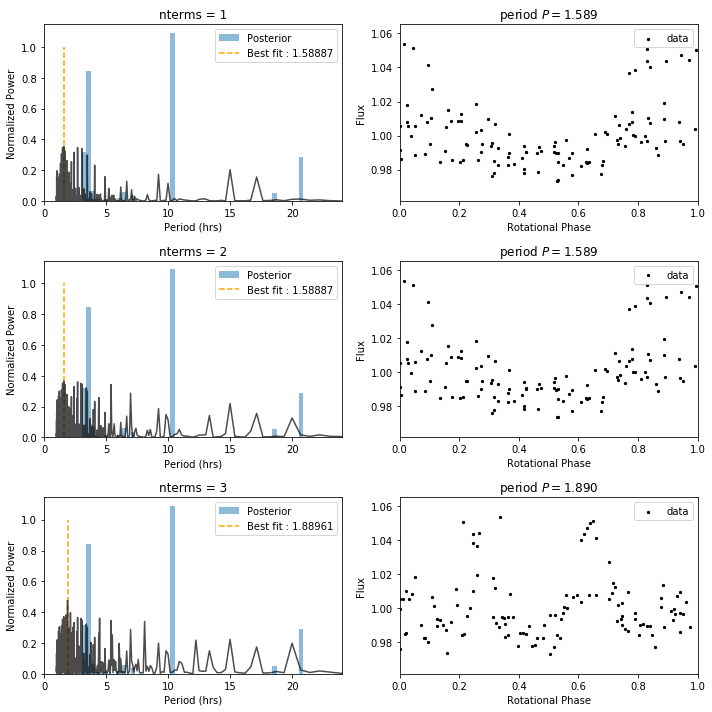

In [15]:
run_lsp(time, flux, flux_err)

In [ ]:
  fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    #if data_pts is not None:
    fig.suptitle("Data points: " + str(f.attrs['data_pts']) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(f.attrs['acceptance_faction'])))

    #else:
    #    fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(f.attrs['acceptance_fraction'])))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(f.attrs['iterations'])

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)
            # fit might guess period is time range of sampling

        flatchain = data[:,i]
    